In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML
from scipy.stats import norm
from scipy.stats import uniform
from numpy.random import default_rng

```{margin}
This section draws from Chapter 5 of _Deep Learning_ by Goodfellow, Bengio, and Courville.
```

# Parameter Estimation: Estimators

<!--- Outline

1. Parameter estimation problem 
    * estimator is a procedure
    * bias and variance;  B-V tradeoff (goodfellow p 120)
2. concept of model fitting
    * parameters and data ; notation and concepts (examples)
2. Maximum likelihood principle
    * likelihood is thinking of $p(x; \theta)$ as a function of $\theta$
    * Goodfellow p 128 for defns;  perhaps use some background from earlier pages
3. Simple examples
    * binomial.  solve in closed form
4. Log-likelihood and cross-entropy loss (goodfellow p 129 ff)
    * difference between the distribution of the data and the distribution of the model
    * did not cover this in the end -- should we?
5. Simple examples
    * poisson
6. Model fitting: least squares (godfellow p 130) (they will have seen least squares in DS 121)
    * this is important - introduce the "model for which the method is an MLE" idea
    * but may need to move to next lecture
    * did not cover this in the end
7. Properties of ML estimate (goodfellow p 131)
--->

### Some Key Concepts of Sampling

A __population__ is the universe of possible data for a specified object. It can be people, places, objects, and many other things. It is not observable.
<br>
__Example__. People (or IP addresses) who have visited or will visit a website.

A __sample__ is a subset of the population. It is observable.
<br>
__Example__. People who visited the website on a specific day. 

<center>
    
<img src="images/population_sample.png" width="500px"/>  
  
</center>

<!-- source: https://www.omniconvert.com/what-is/sample-size/ -->   

__Question__.  An organization wants to survey the variance of calcium intake among high school students. They collaborate with three high schools and obtain the calcium intake of in total 60 students.

Which statement is correct?

a. The sample data is the calcium intake of 60 students and the population data is the calcium intake of all high school students.

b. The sample data is the calcium intake of all high school students and the population data is the calcium intake of 60 students.

__Answer__. a

## What is a statistic?

A __statistic__ is anything (i.e., any function) that can be computed from the collected data sample. A statistic must be observable.

__Question__. A lightbulb manufacturer believes that the lifetimes of a certain type of lightbulb follow an exponential distribution with parameter $\lambda$. To test this hypothesis the manufacturer measures the lifetime of 10 bulbs and gets data $x_1, \dots,x_{10}$.

Which of the following is a statistic?

a. The sample average, $\overline{x} = \frac{x_1+x_2+\dots+x_{10}}{10}$.

b. The population mean, $\frac{1}{\lambda}$. 

c. The difference between $\overline{x}$ and $\frac{1}{\lambda}$.

__Answer__. a

## Parameter Estimation

__Example__. We are studying the variance of height among male students at BU. Our sample of size 30 is shown below. We want to fit normal distribution $\mathcal{N}(\mu, \sigma^2)$ to this data. 

What values should we choose for $\mu$ and $\sigma$?

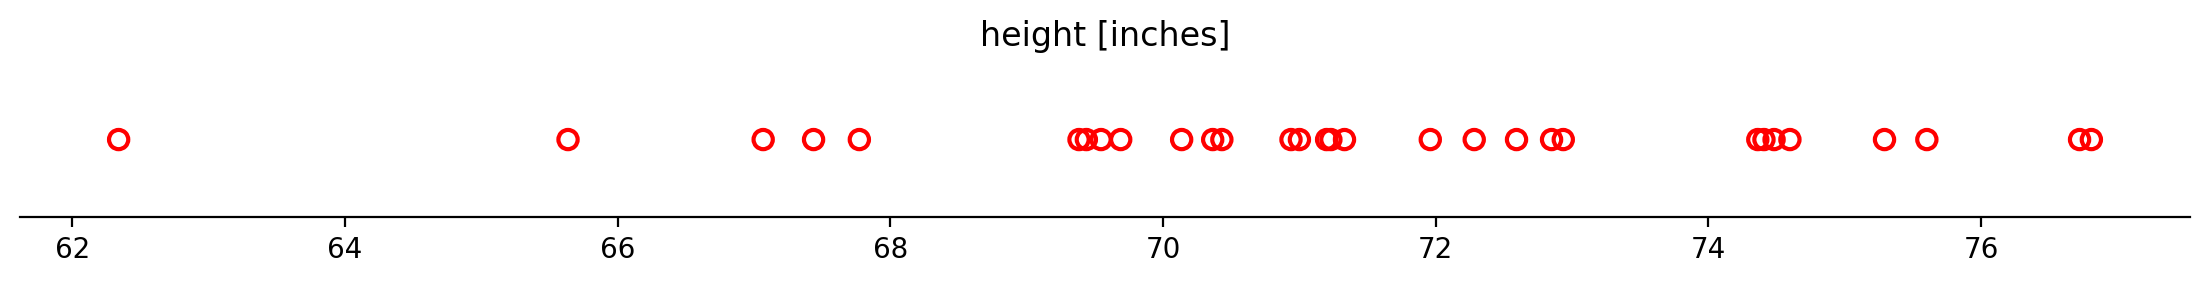

In [2]:
from scipy.stats import norm
from scipy.stats import uniform
from numpy.random import default_rng

# specify the parameters
mu = 70 
sig = 3
#
samp_size = 30
rng = 0

fig, ax = plt.subplots(1, 1, figsize = (14,1))

# sample
samp_x = norm.rvs(size = samp_size, loc = mu, scale = sig, random_state = rng)
samp_y = [1 for x in samp_x]
ax.scatter(samp_x, samp_y, marker = 'o', facecolors='none', edgecolors='red', linewidths = 1.5, s = 48)
#ax.set_xlim(xmin, xmax)
ax.set_title('height [inches]')
ax.yaxis.set_visible(False)
# remove the "box" around the plot
for spine in [list(ax.spines.values())[i] for i in [0, 1, 3]]:
    spine.set_visible(False)

Here, $\mu$ and $\sigma$ are the population __parameters__. They are fixed but unknown.

__Parameter estimation__ is inference about an unknown population parameter (or set of population parameters) based on a sample statistic.

Parameter estimation is a commonly used statistical technique. For instance, traffic engineers estimate the rate $\lambda$ of the Poisson distribution to model light traffic (individual cars move independently of each other). Their data constists of the counts of vehicles that pass a marker on a roadway during a unit of time.

In other words, we need parameter estimation when we are given some data and we want to treat it as an __independent and identically distributed (or i.i.d.)__ sample from some population  distribution. The distribution has certain parameters, such as $\lambda$ in the above example or $\mu$ and $\sigma$ in the example of height among male students at BU. 

We will use $\theta$ (which can be a scalar or a vector) to represent the parameter(s).  For example, we could have $\theta = (\mu, \sigma).$ 

## Point Estimation

__Example__. The sample average of 71.3 inches is a __point estimate__ of the average height of male students at BU.

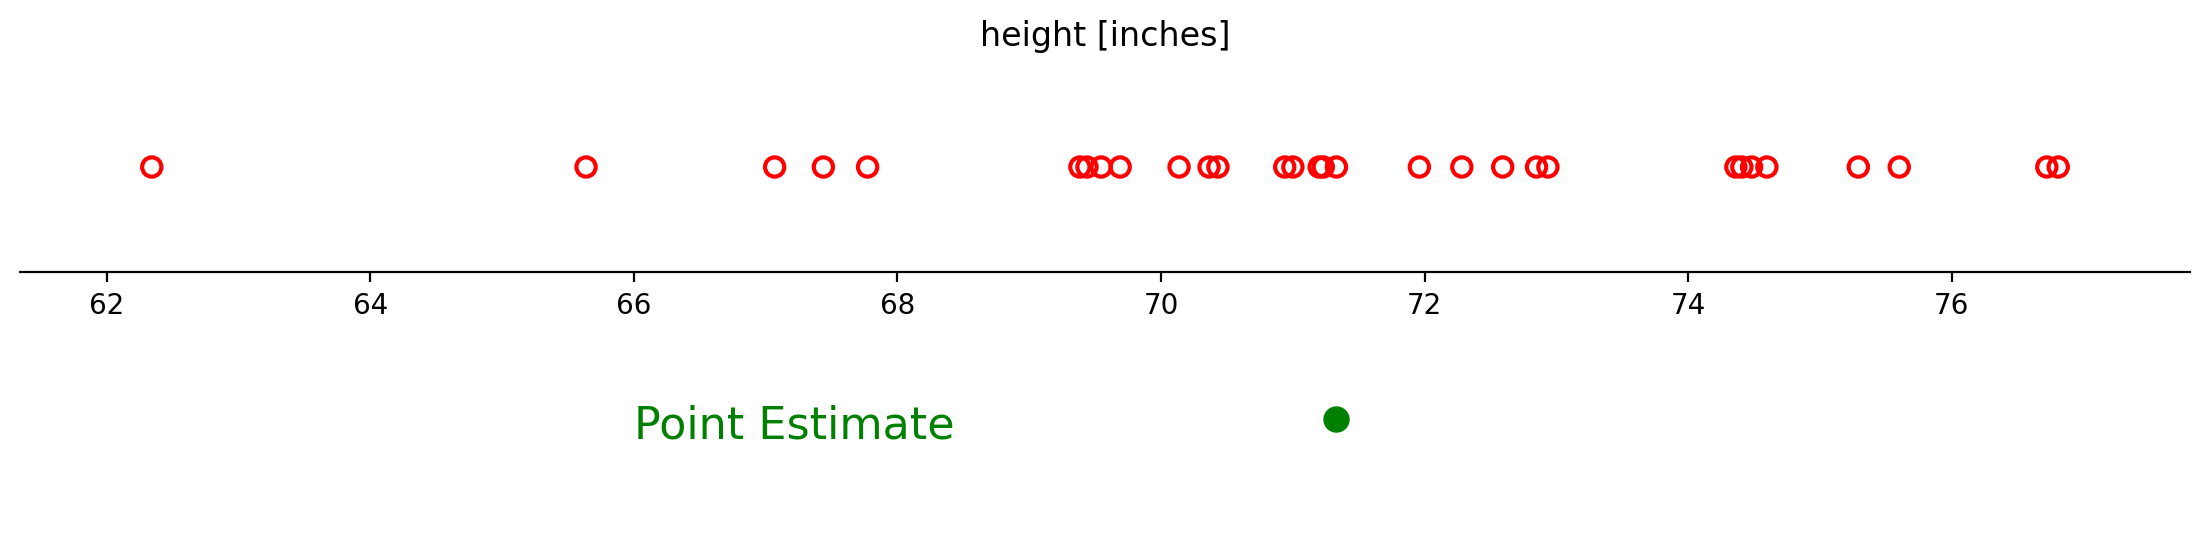

In [3]:
# to define the range of the figure
xmin, xmax = (min(samp_x)-1, max(samp_x)+1)
# compute the sample mean
#print(np.mean(samp_x))
xmean = np.mean(samp_x)

# make the plot
fig, (ax, ax1) = plt.subplots(2, 1, figsize = (14,3))

# show the sample
ax.scatter(samp_x, samp_y, marker = 'o', facecolors='none', edgecolors='red', linewidths = 1.5, s = 48)
ax.set_xlim(xmin, xmax)
ax.set_title('height [inches]')
ax.yaxis.set_visible(False)
# remove the "box" around the plot
for spine in [list(ax.spines.values())[i] for i in [0, 1, 3]]:
    spine.set_visible(False)

# show the mean
ax1.scatter(xmean, 1, marker = 'o', facecolors = 'g', edgecolors='g', linewidths = 1.5, s = 64)
ax1.set_xlim(xmin, xmax)
ax1.text(66, np.sum(ax1.get_ylim())/2 - 0.01, 'Point Estimate', size = 16, color = 'g')
ax1.yaxis.set_visible(False)
ax1.xaxis.set_visible(False)
# remove the "box" around the plot
for spine in ax1.spines.values():
    spine.set_visible(False)

A __point estimator__ is a statistic that is used to estimate the unknown population parameter and whose realisation is a single point. 

Let's say our data is $\{x^{(1)}, \dots, x^{(m)}\}$. A __point estimator__ can be any function $g$ of the data:

$$ \hat{\theta}_m = g\left(x^{(1)}, \dots, x^{(m)}\right). $$

We'll use the hat notation ($\hat{\theta}$) to indicate a point estimator of $\theta$.

Note: The above definition does not require that $g$ returns a value that is close to the parameter(s) $\theta$. So any function qualifies as an estimator. However, a good estimator is a function whose output is close to $\theta$.

__Question__. Will the point estimate change if a different sample is selected?

__Answer__. Yes, the point estimate varies from sample to sample.

In the frequentist perspective on statistics, $\theta$ is __fixed but unknown,__ while $\hat{\theta}$ is a function of the data. Therefore, $\hat{\theta}$ is a __random variable__ which has a probability distribution referred to as its __sampling distribution__.


This is a very important perspective to keep in mind;  it is really the defining feature of the frequentist approach to statistics!

The __sampling distribution__ of a statistic is the probability distribution of that statistic when we draw many samples. 

<center>
    
<img src="images/sampling_distribution.png">
   
</center>

<!-- based on https://creativemaths.net/blog/sampling-distribution/ -->

The figure shows a population distribution (left) and the corresponding sampling distribution (right) of a statistic, which in this case is the mean. The sampling distribution is obtained by drawing samples of size n from the population.

Recall that Bernoulli random variable has
- only two outcomes: 0 and 1
- one parameter $p$, which is the probability that the random variable is equal to 1
- mean equal to $p$ and variance equal to $p(1-p)$.

<center>

<img src="images/Coin_Toss.jpg" width="300px">
    
</center>

<!-- By ICMA Photos - Coin Toss, CC BY-SA 2.0, https://commons.wikimedia.org/w/index.php?curid=71147286 -->

__Example.__ Consider data sample $\{x^{(1)}, \dots, x^{(m)}\}$ drawn independently and identically from a Bernoulli distribution with mean $\theta$:

$$ p\left(x^{(i)}; \theta\right) = \theta^{x^{(i)}}\left(1-\theta\right)^{\left(1-x^{(i)}\right)}. $$

A common estimator for $\theta$ is the mean of the realizations:
    
$$ \hat{\theta}_m = g\left(x^{(1)}, \dots, x^{(m)}\right) = \frac{1}{m}\sum_{i=1}^m x^{(i)}. $$

## Bias and Variance

We use two criteria to describe an estimator: __bias__ and __variance.__

Bias measures the difference between the expected value of the estimator and the true value of the parameter, while variance measures how much the estimator can vary as a function of the data sample. 

__Question__. What are the properties of a good estimator?

a. High bias and high variance

b. High bias and low variance

c. Low bias and high variance

d. Low bias and low variance

__Answer__. d

We would ideally like an estimator that is unbiased and has a low variance.

<center>

<img src="images/bias_variance_tradeoff.png" width="500px">
    
</center>

<!-- By Sebastian Raschka https://sebastianraschka.com/blog/2016/model-evaluation-selection-part2.html -->

__Question__. The histograms below show an approximation to the sampling distribution for four estimators of the same population parameter. If the actual value of the population parameter is 6, which histogram displays the estimator with relatively low bias and high variance?

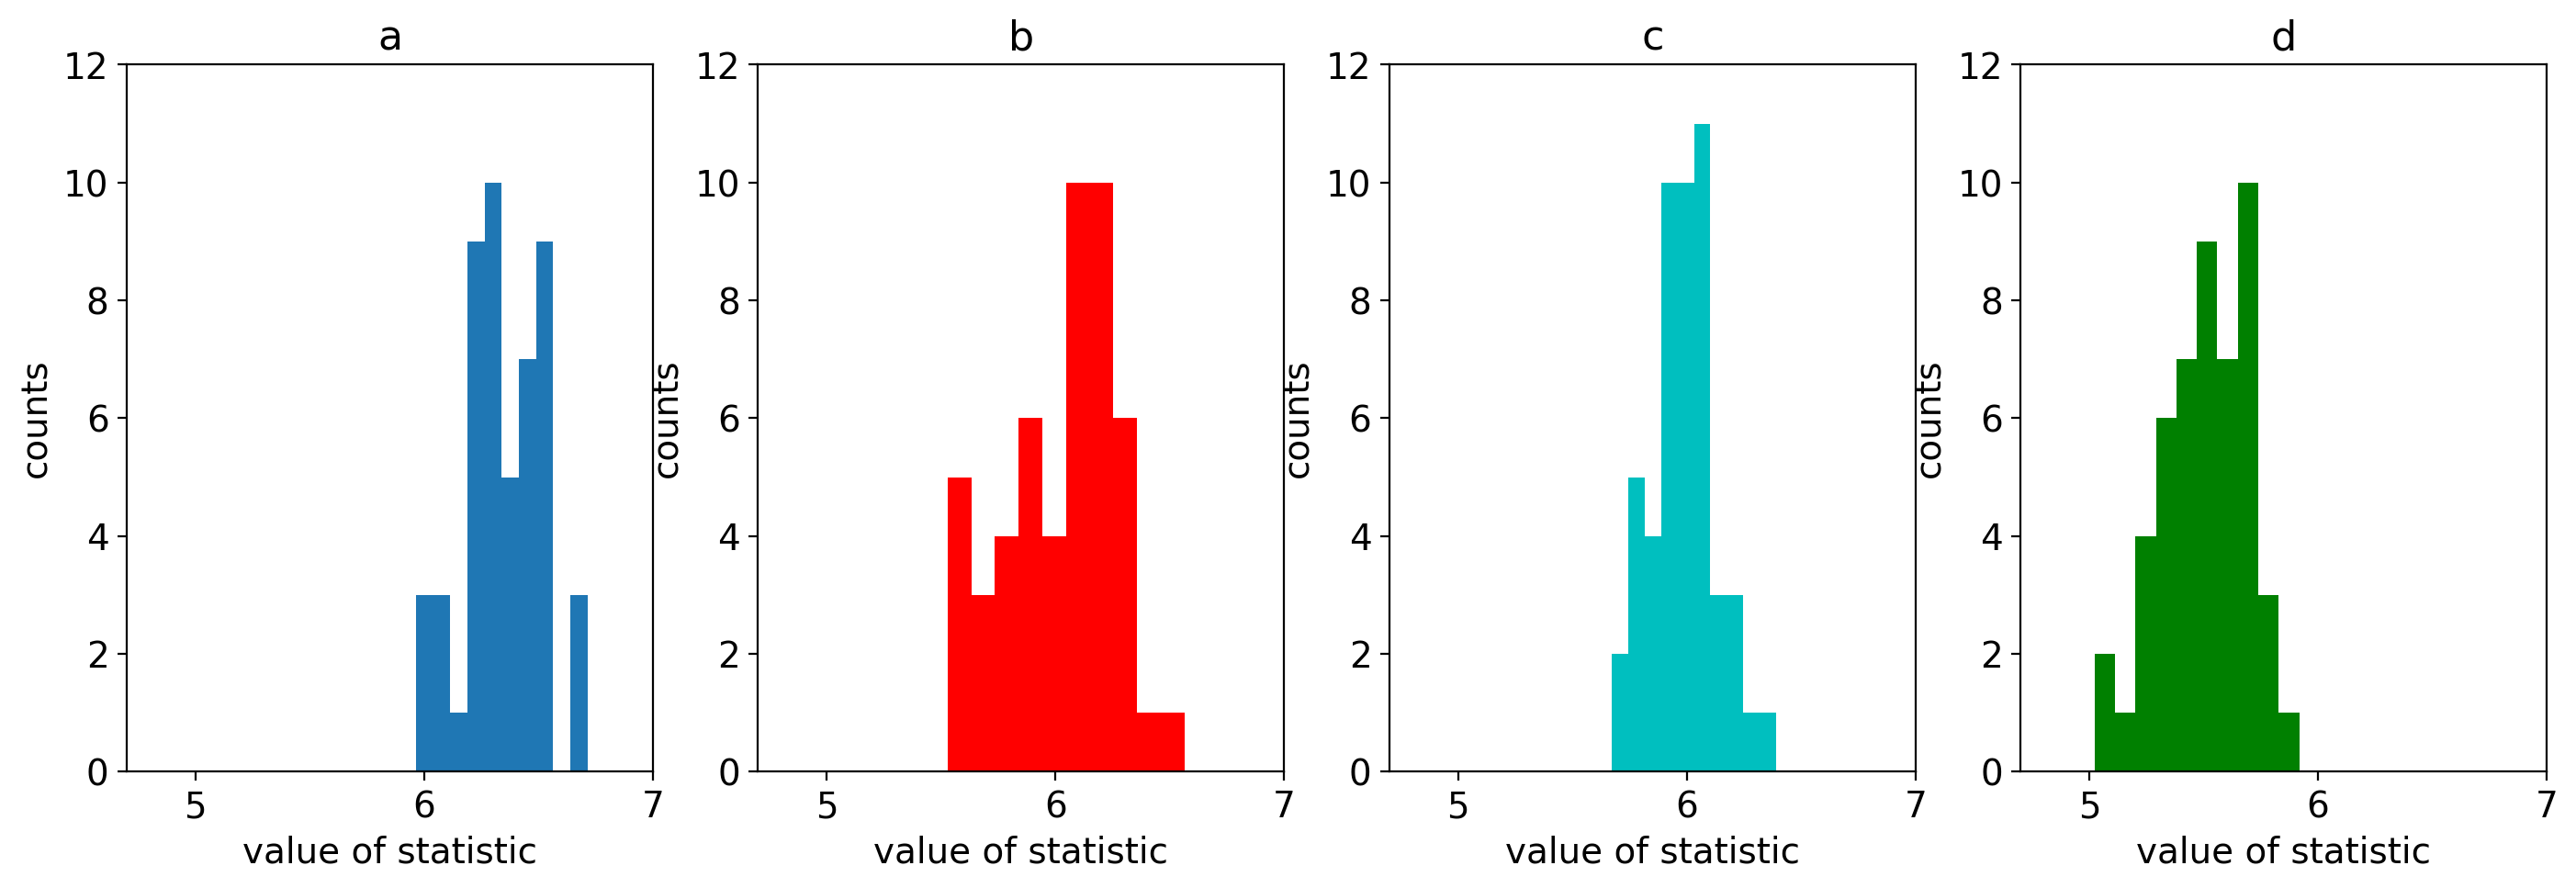

In [21]:
mu = [6.35, 6, 6, 5.5]
sig = [0.2, 0.25, 0.15, 0.2]
#
samp_size = 50
rng = default_rng(12)

# s = rng.normal(mu[3], sig[3], samp_size)
# print(s)
# plt.hist(s, bins=20)
# plt.show()

fig, axs = plt.subplots(1, 4, figsize=(17, 5))
axs[0].hist(rng.normal(mu[0], sig[0], samp_size), bins=10)
axs[0].set_xlim(4.7, 7)
axs[0].set_ylim(0, 12)
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].set_title('a', fontsize = 16)
axs[1].hist(rng.normal(mu[1], sig[1], samp_size), bins=10, color = 'r')
axs[1].set_xlim(4.7, 7)
axs[1].set_ylim(0, 12)
axs[1].set_title('b', fontsize = 16)
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[2].hist(rng.normal(mu[2], sig[2], samp_size), bins=10, color = 'c')
axs[2].set_xlim(4.7, 7)
axs[2].set_ylim(0, 12)
axs[2].set_title('c', fontsize = 16)
axs[2].tick_params(axis='both', which='major', labelsize=14)
axs[3].hist(rng.normal(mu[3], sig[3], samp_size), bins=10, color = 'g')
axs[3].set_xlim(4.7, 7)
axs[3].set_ylim(0, 12)
axs[3].tick_params(axis='both', which='major', labelsize=14)
axs[3].set_title('d', fontsize = 16)

for ax in axs.flat:
    ax.set(xlabel='value of statistic', ylabel='counts')
    ax.xaxis.label.set_size(14)
    ax.yaxis.label.set_size(14)

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()

__Answer__. b

__Bias.__ The _bias_ of an estimator is defined as:
    
$$ \operatorname{bias}\left(\hat{\theta}_m\right) = E\left[\hat{\theta}_m\right] - \theta, $$

where the expectation is over the data (seen as realizations of a random variable) and $\theta$ is the true underlying value of $\theta$ used to define the data-generating distribution.

An estimator is said to be __unbiased__ if $ \operatorname{bias}\left(\hat{\theta}_m\right) = 0$, or in other words $E\left[\hat{\theta}_m\right] = \theta$.

Continuing our example for the mean of the Bernoulli:
    
$$ \operatorname{bias}\left(\hat{\theta}_m\right) = E\left[\hat{\theta}_m\right] - \theta \\
= E\left[\frac{1}{m} \sum_{i=1}^m x^{(i)} \right] - \theta $$

$$ = \frac{1}{m} \sum_{i=1}^m E\left[x^{(i)} \right] - \theta \\
= \frac{1}{m} \sum_{i=1}^m \sum_{x^{(i)}=0}^1 \left(x^{(i)} \theta^{x^{(i)}}\left(1-\theta\right)^{\left(1-x^{(i)}\right)}\right) - \theta $$

$$ = \frac{1}{m} \sum_{i=1}^m (\theta) - \theta\\
= \theta - \theta = 0$$

So we have proven that this estimator of $\theta$ is unbiased.

__Variance.__  The _variance_ of an estimator is simply the variance

$$ \operatorname{Var}\left(\hat{\theta}\right) = \operatorname{Var}\left(g\left(x^{(1)}, \dots, x^{(m)}\right)\right)$$

where $g\left(x^{(1)}, \dots, x^{(m)}\right)$ is a function of the data set.   

Remember that the data set is random; it is assumed to be an i.i.d. sample of some distribution.

Recall: 
1. If $\operatorname{Var}(X)$ exists and $Y=a+bX$, then $\operatorname{Var}(Y) = b^2\operatorname{Var}(X)$.
2. If $\{X_1, X_2, \dots, X_m\}$ are i.i.d., then $\operatorname{Var}\sum_{i=1}^m X_i = m\operatorname{Var}\left(X_1\right).$

Let us return again to our example where the sample is drawn from the Bernoulli distribution and the estimator $\hat{\theta}_m = \frac{1}{m}\sum_{i=1}^m x^{(i)}$ is simply the mean of $m$ observations.

So we see that the variance of the mean is:

$$\operatorname{Var}\left(\hat{\theta}_m\right) = \operatorname{Var}\left( \frac{1}{m} \sum_{i=1}^m x^{(i)} \right)
=\frac{1}{m^2}\operatorname{Var}\left( \sum_{i=1}^m x^{(i)} \right) $$

$$ = \frac{1}{m^2} m \operatorname{Var}\left(x^{(1)}\right)
= \frac{1}{m}\theta (1-\theta).$$

This has a desirable property: as the number of data points $m$ increases, the variance of the estimate decreases.

Note: It can be shown that for a sample $\{x^{(1)}, \dots, x^{(m)}\}$ drawn independently and identically from any population with mean $\mu$ and variance $\sigma^2$. The sample mean, $\frac{1}{m}\sum_{i=1}^m x^{(i)}$, is an unbiased estimator of the population mean and has variance $\frac{\sigma^2}{m}$.

What if we use $\hat{\beta}_m = c$, where $c$ is a constant, to estimate the population mean in our Bernoulli example?

The variance of this estimator is equal to

$$\operatorname{Var}\left(\hat{\beta}_m\right) = \operatorname{Var}(c) = 0.$$

However, the bias in this case is equal to

$$\operatorname{bias}(\hat{\beta}_m) = E\left[\hat{\beta}_m\right] - \theta = E[c] - \theta = c - \theta.$$

The estimator $\hat{\beta}_m = c \:$ is biased. 

## Mean Squared Error

Consider two estimators, $g$ and $h$, each of which are used as estimates of a certain parameter $\theta$.

Let us say that these estimators show the following distributions:

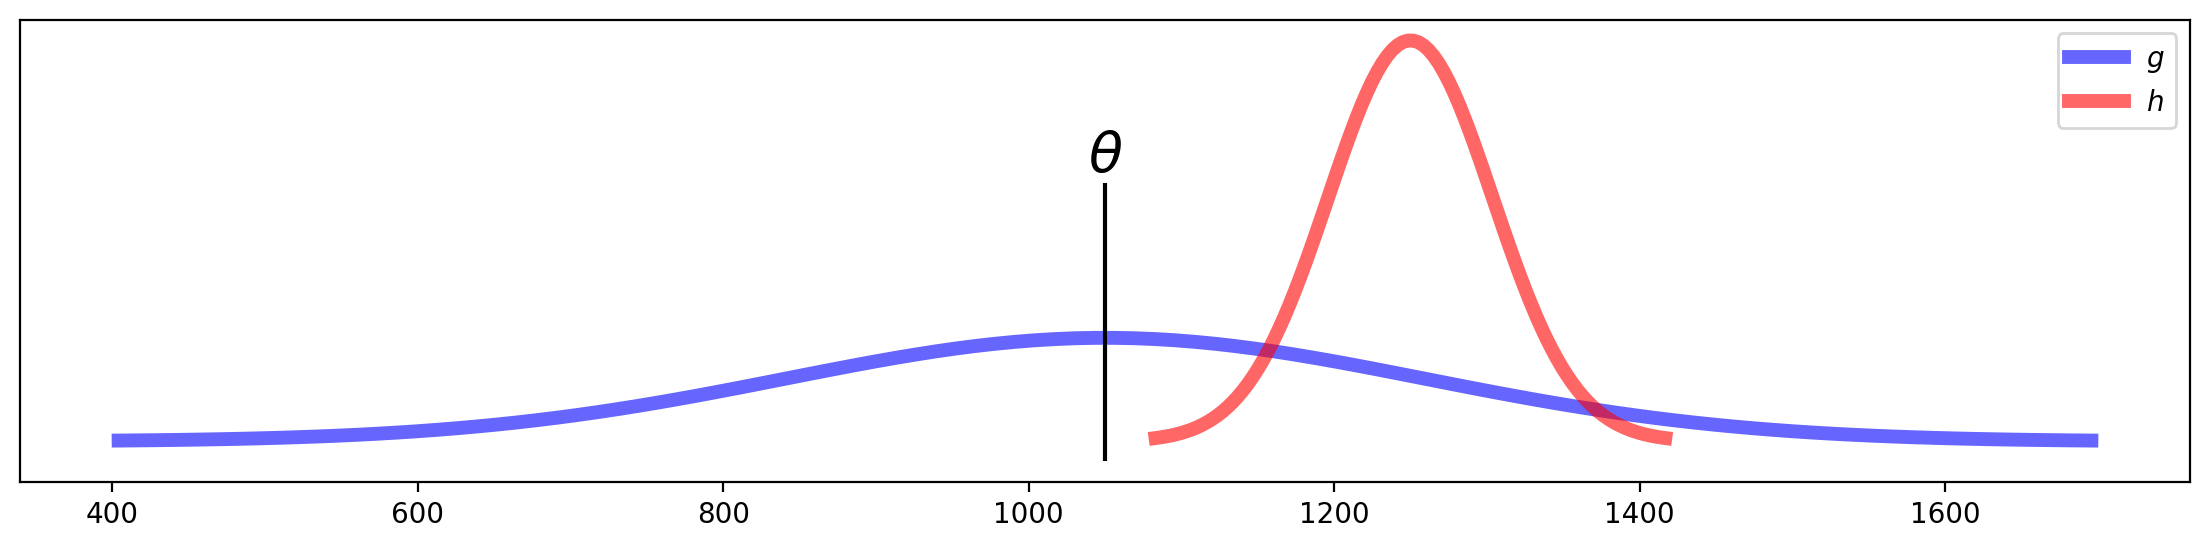

In [5]:
from scipy.stats import norm
from scipy.stats import uniform
from numpy.random import default_rng

rng = default_rng(12)

# just some numbers that make a nice plot
mu = 1050
sig = 209
# MSE of estimator of k having dist (mu, sigma) is sigma^2 + (mu - k)^2
mse1 = sig**2
#
offset = 200
mu2 = mu + offset
sig2 = 54
mse2 = (offset**2) + (sig2**2)
# print(mse1, mse2)
#
samp_size = 15
#
# gaussian curve
fig, ax = plt.subplots(1, 1, figsize = (14,3))
x = np.linspace(norm.ppf(0.001, loc = mu, scale = sig), norm.ppf(0.999, loc = mu, scale = sig), 100)
ax.plot(x, norm.pdf(x, loc = mu, scale = sig),'b-', lw = 5, alpha = 0.6, label = '$g$')
x = np.linspace(norm.ppf(0.001, loc = mu2, scale = sig2), norm.ppf(0.999, loc = mu2, scale = sig2), 100)
ax.plot(x, norm.pdf(x, loc = mu2, scale = sig2),'r-', lw = 5, alpha = 0.6, label = '$h$')
xmin, xmax = (x[0], x[-1])
plt.legend(loc = 'best')
# sample plot
# turn off y axis entirely
ax.yaxis.set_visible(False)
#
# vertical line
ymin, ymax = ax.get_ylim()
plt.vlines(x = mu, ymin = ymin, ymax = ymax-.003, color = 'k')
plt.text(mu, ymax-0.003, r'$\theta$', size = 20, ha = 'center', va = 'bottom');
# hide x axis but not its label
# ax.xaxis.set_major_locator(plt.NullLocator())
# remove the "box" around the plot
#for spine in ax.spines.values():
#    spine.set_visible(False)
# ax.text(1600, np.sum(ax2.get_ylim())/2 - 0.03, 'Sample', size = 16, color = 'red')

The figure shows that estimator $h$ has low variance, but is biased.   Meanwhile, estimator $g$ is unbiased, but has high variance.

Which is better?

The answer of course depends, but there is a single criterion we can use to try to balance these two kinds of errors.

It is __Mean Squared Error.__

$$ \operatorname{MSE}\left(\hat{\theta}_m\right) = E\left[\left(\hat{\theta}_m - \theta\right)^2\right] $$

This measures the "average distance squared" between the estimator and the true value.

It is a good single number for evaluating an estimator, because it turns out that:
    
$$ \operatorname{MSE}\left(\hat{\theta}_m\right) = \operatorname{bias}\left(\hat{\theta}_m\right)^2 + \operatorname{Var}\left(\hat{\theta}_m\right) $$

For example, the two estimators $g$ and $h$ in the plot above have approximately the same MSE.

__Question__. Consider again data sample $\{x^{(1)}, \dots, x^{(m)}\}$ drawn independently and identically from a Bernoulli distribution with mean $\theta$:

$$ p\left(x^{(i)}; \theta\right) = \theta^{x^{(i)}}\left(1-\theta\right)^{\left(1-x^{(i)}\right)} $$

and the estimator 

$$ \hat{\theta}_m = g\left(x^{(1)}, \dots, x^{(m)}\right) = \frac{1}{m}\sum_{i=1}^m x^{(i)}. $$

Find the MSE for this estimator.

We have already shown that for sample $\{x^{(1)}, \dots, x^{(m)}\}$ that is drawn independently and identically from a Bernoulli distribution with mean $\theta$, the estimator $\hat{\theta}_m = \frac{1}{m}\sum_{i=1}^m x^{(i)}$ is unbiased and and has variance $\frac{1}{m}\theta (1-\theta)$. Therefore, 

$$MSE\left({\hat{\theta}}_m\right) = \operatorname{Var}\left({\hat{\theta}}_m\right) = \frac{1}{m}\theta (1-\theta).$$

### Python example

Consider the following i.i.d. data sample of size 35.

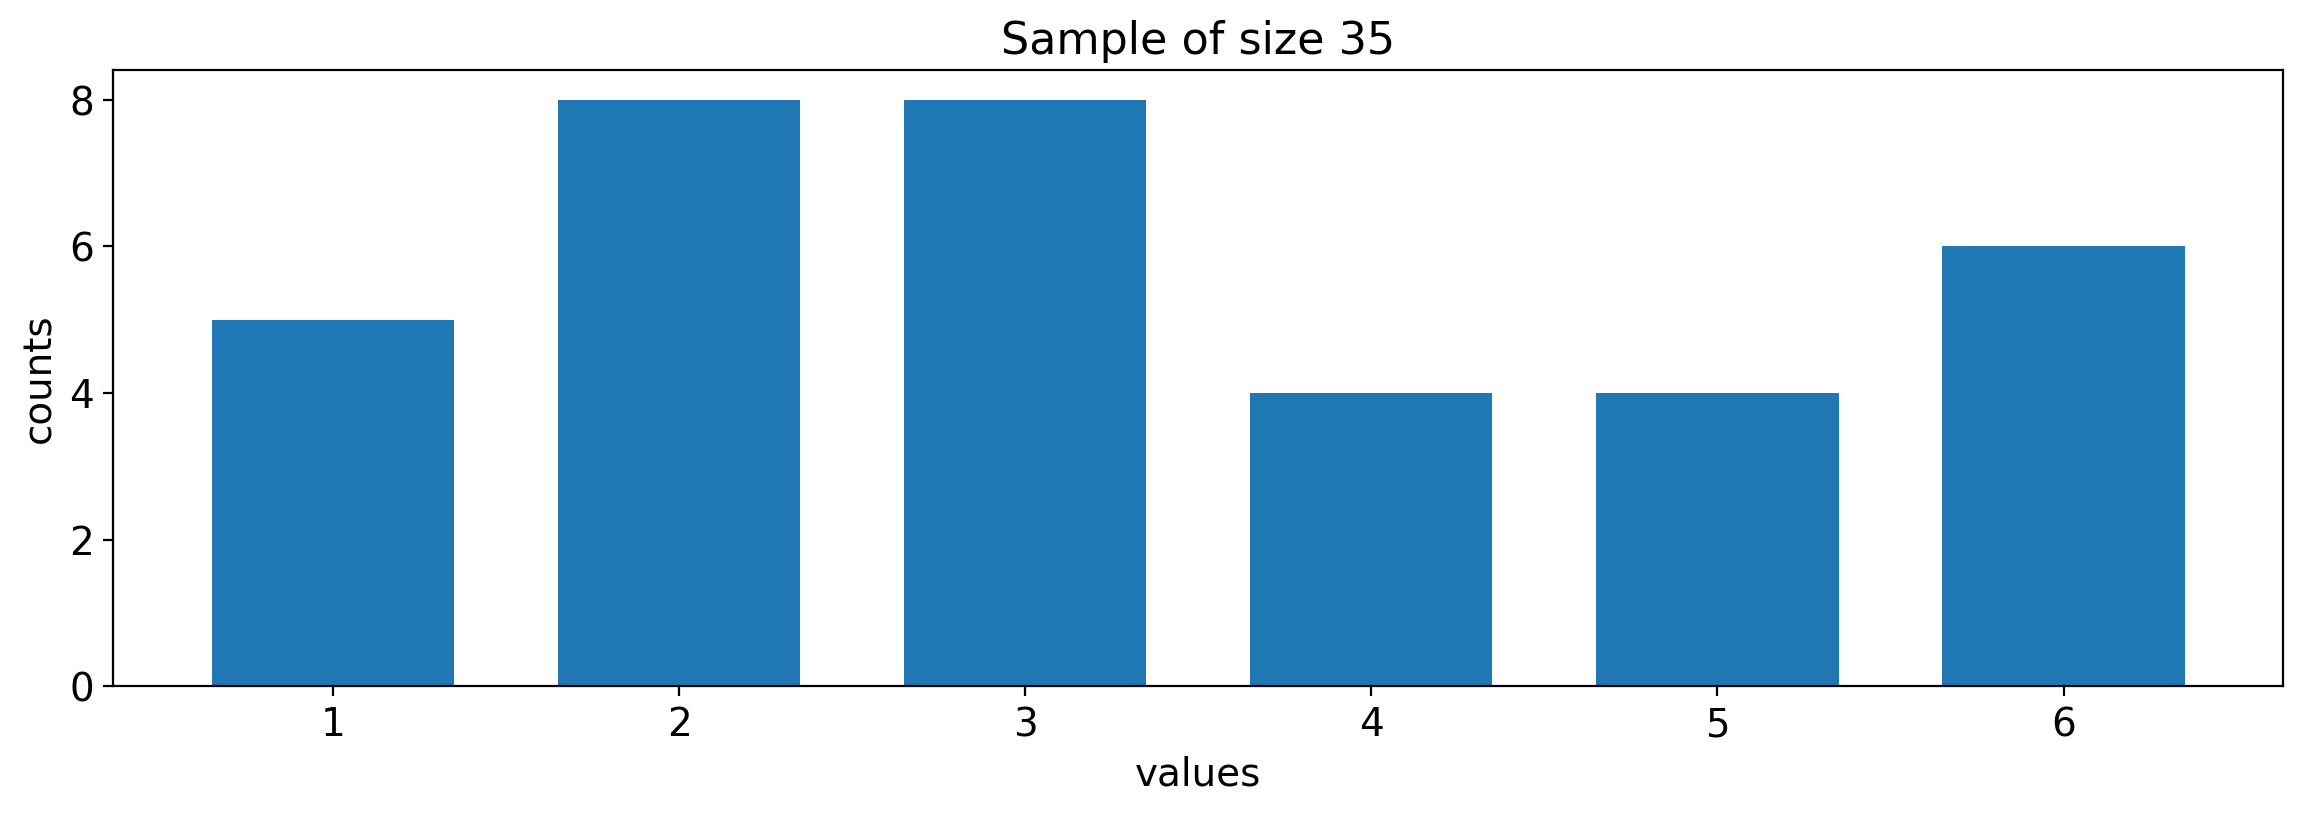

In [25]:
import statistics
from collections import Counter

samp_size = 35
rng = default_rng(12)

s = rng.integers(1, 7, size = samp_size)
freqs = Counter(s)
#print(s)
fig, axs = plt.subplots(1, 1, figsize=(14,4))
axs.bar(freqs.keys(), freqs.values(), width=0.7)
axs.set_title(f'Sample of size {samp_size}', fontsize = 16)
axs.set(xlabel='values', ylabel='counts')
axs.xaxis.label.set_size(14)
axs.yaxis.label.set_size(14)
axs.tick_params(axis='both', which='major', labelsize=14)
plt.show()

Is the sample from a discrete uniform distribution? Do the values range from 1 to 6?

Discrete uniform distribution:

<center>

<img src="images/Uniform_discrete_pmf.svg" width="350px">
    
</center>

<!-- By IkamusumeFan - This drawing was created with LibreOffice Draw., CC BY-SA 3.0, https://commons.wikimedia.org/w/index.php?curid=27391798 -->

$n = b - a +1$

parameters: $a$ and $b$ <br>
mean: $\frac{a+b}{2}$ <br>
variance: $\frac{n^2-1}{12} = \frac{(b - a +1)^2 -1}{12}$     

If the population distribution is $U(1,6)$, the population mean should be equal to 3.5 and the population variance should be approximately 2.917. 

We can use the provided sample to estimate the population mean and variance.

Note: We are not fitting $U(1,6)$ to the sample. We are simply looking for point estimates for the population mean and variance.

We discussed earlier that regardless of the population distribution, the sample mean is an unbiased estimator of the population mean and its variance is inversely proportional to the size of the sample.

Thus we will use the sample average to estimate the population mean:

$$\hat{\theta} = \frac{1}{35}\sum_{i=1}^{35} x^{(i)}.$$

In [7]:
# compute the sample mean
mu_hat = np.mean(s)
print(f'The estimate of the population mean is equal to {mu_hat:.4}.')

The estimate of the population mean is equal to 3.343.


What about the population variance? Can it be estimated by

$$\frac{\sum_{i=1}^{m} \left(x^{(i)} - \overline{x}\right)^2}{m} = \frac{\sum_{i=1}^{35} \left(x^{(i)} - \overline{x}\right)^2}{35}?$$

In [8]:
# compute the variance of the sample (without Bessel's correction)
sig2_hat_1 = np.var(s, axis = 0, ddof = 0)
print(f'The biased sample variance is equal to {sig2_hat_1:0.4}.')

The biased sample variance is equal to 2.797.


We will see later in this lecture that this estimator systematically underestimates the population variance. __Bessel's correction__ is required to obtain an unbiased estimator:

$$\frac{\sum_{i=1}^{m-1} \left(x^{(i)} - \overline{x}\right)^2}{m-1} = \frac{\sum_{i=1}^{34} \left(x^{(i)} - \overline{x}\right)^2}{34}.$$

The above expression is known as sample variance.

In [9]:
# compute the sample variance (with Bessel's correction)
sig2_hat_2 = np.var(s, axis = 0, ddof = 1)
print(f'The unbiased sample variance is equal to {sig2_hat_2:0.4}.')

The unbiased sample variance is equal to 2.879.


__Conclusion__. Based on the provided sample, the population mean can be estimated by 3.343 and the population variance can be estimated by 2.879. These values are close to 3.5 and 2.917, respectively. Therefore, $U(1,6)$ can be considered a "good guess" for the population distribution.

### Effect of Bessel's correction

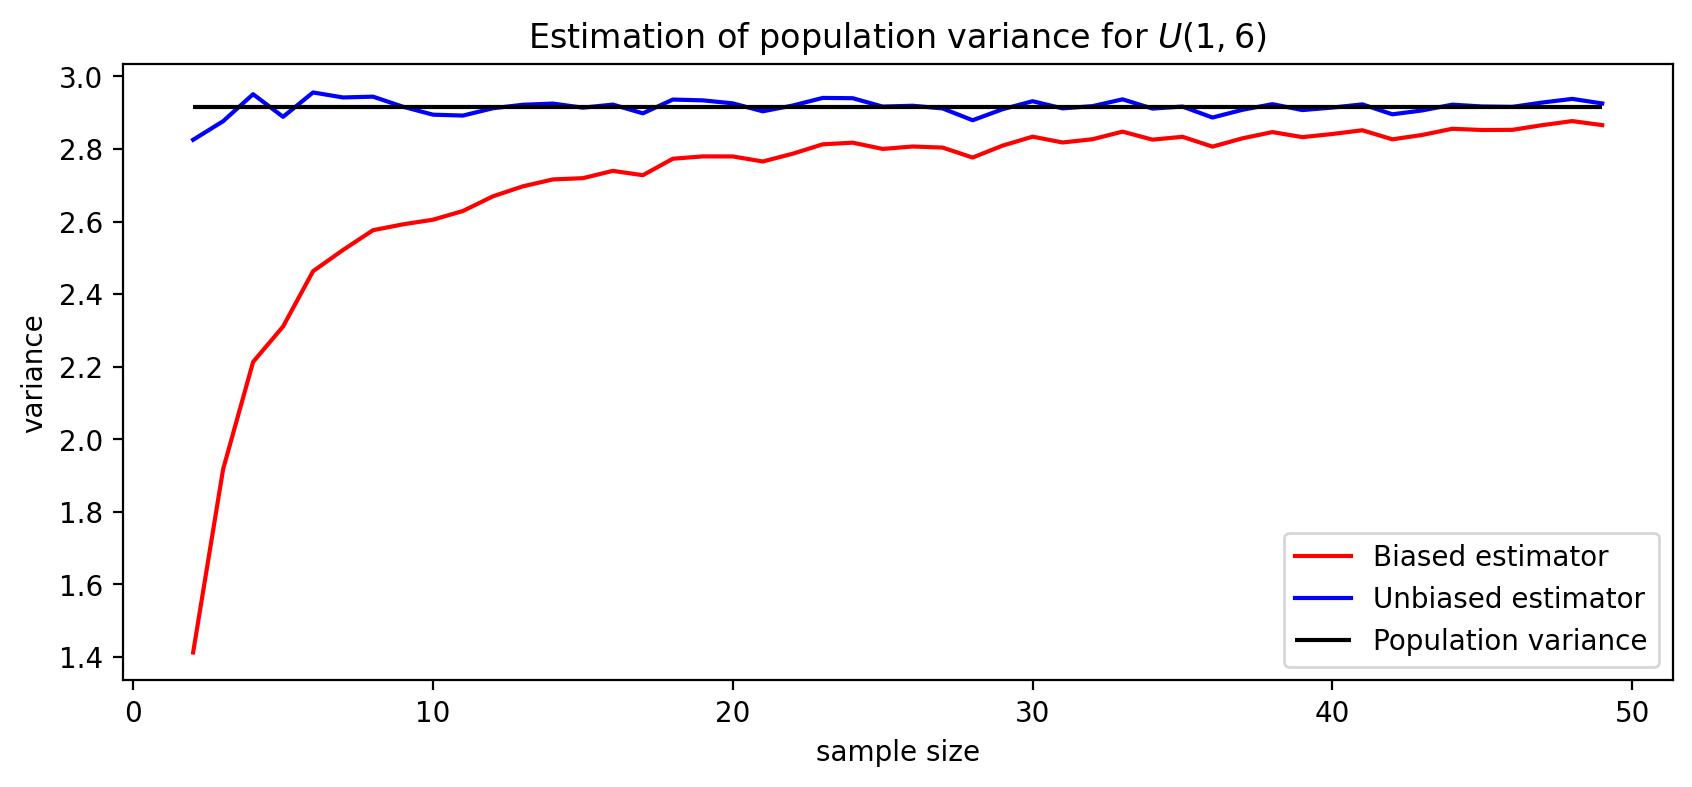

In [10]:
# For sample sizes between 2 and 50, we'll collect 1000 samples from U(1,6).  
# We will look at the average value of the calculated sample variance and the variance of 
# the sample without Bessel's correction.

samp_sizes = np.arange(2,50)
n_samps = 1000

# distribution parameters
a = 1
b = 6

rng = default_rng(123)

biased_pvar = []
unbiased_pvar = []
for samp_size in samp_sizes:
    samps =[]
    for i in range(n_samps):
        # create the samples of certain size
        samps[i:] = [rng.integers(a, b+1, size = samp_size)]
    # compute the variance of each sample without Bessel's correction
    biased_pvar_samp = [np.var(samp, axis = 0, ddof = 0) for samp in samps]
    # compute the variance of each sample with Bessel's correction
    unbiased_pvar_samp = [np.var(samp, axis = 0, ddof = 1) for samp in samps]
    # take the mean variance
    biased_pvar.append(np.mean(biased_pvar_samp))
    unbiased_pvar.append(np.mean(unbiased_pvar_samp))

#plot results
plt.figure(figsize = (10,4))
plt.plot(samp_sizes, biased_pvar, label="Biased estimator", color = 'r')
plt.plot(samp_sizes, unbiased_pvar, label="Unbiased estimator", color = 'b')

# horizontal line
pvar = ((b-a+1)**2-1)/12
plt.hlines(y = pvar, xmin = samp_sizes[0], xmax = samp_sizes[-1], color = 'k', label = 'Population variance')
plt.title(r'Estimation of population variance for $U(1,6)$')
plt.xlabel('sample size')
plt.ylabel('variance')
plt.legend()
plt.show() 

Note: The $y$-axis corresponds to the variance that is obtained by taking an average over 1000 samples for each sample size.

### Summary

1. Parameter estimation is inference about a population parameter (or set of population parameters) based on a sample statistic. The parameter is (or parameters are) fixed but unknown.

2. Point estimation is single point estimatation of the population parameter(s). The point estimator is a random variable.

3. Evaluation of the estimator:
- Bias: it measures the expected deviation from the true value of the parameter. A good estimator has low bias.
- Variance: it measures how much the estimator can vary as a function of the data sample. A good estimator has low variance.
- Mean Squared Error: it measures the "average distance squared" between the estimator and the true value. It incorporates both the bias and the variance.

### Extra: Intuition behind Bessel's correction

<center>

<img src="images/Bessel_correction.png" width="800px">
    
</center>

<!-- From math with bad drawings -->

__Extra Question__. Suppose $\{x^{(1)},x^{(2)} \dots, x^{(n)}\}$ is an i.i.d. sample from the exponential distribution with rate $\lambda$. Consider the following estimator for $\theta = \frac{1}{\lambda}$:

$$\hat{\theta} = \frac{1}{n+1}\sum_{i=1}^n x^{(i)}.$$

a. Find the bias of $\hat{\theta}$.<br>
b. Find the variance of $\hat{\theta}$.<br>
c. Find the mean squared error of $\hat{\theta}$.